In [1]:
%cd ../../../fake-profile-detection

f:\Projects\fake-profile-detection


# Preprocessing

In [2]:
from src.eda_pipeline import EDAPipeline
pipe = EDAPipeline()
pipe.get_data('MIB')

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
pipe.dfs.keys()

dict_keys(['user_df', 'tweet_df', 'tweet_metadata_df'])

In [6]:
df_user_before = pipe.dfs['user_df']
is_bot = df_user_before[pipe.label_col] == 1
df_bot_before = df_user_before[is_bot]
df_naive_before = df_user_before[~is_bot]

f'Total: {df_user_before.shape}'
f'Bot: {df_bot_before.shape}'
f'User: {df_naive_before.shape}'

'Total: (9386, 43)'

'Bot: (5912, 43)'

'User: (3474, 43)'

In [7]:
df_user_before.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9386 entries, 0 to 9385
Data columns (total 43 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  9386 non-null   int64  
 1   name                                9385 non-null   object 
 2   screen_name                         9386 non-null   object 
 3   statuses_count                      9386 non-null   int64  
 4   followers_count                     9386 non-null   int64  
 5   friends_count                       9386 non-null   int64  
 6   favourites_count                    9386 non-null   int64  
 7   listed_count                        9386 non-null   int64  
 8   url                                 1947 non-null   object 
 9   lang                                8386 non-null   object 
 10  time_zone                           3695 non-null   object 
 11  location                            3420 no

In [8]:
df_user_before.apply(lambda x: x.unique())

id                                    [24858289, 33212890, 39773427, 57007623, 63258...
name                                  [Davide Bertoli, Elisa D'Ospina, Donato Vincen...
screen_name                           [davideb66, ElisaDospina, Vladimir65, RafielaM...
statuses_count                        [1299, 18665, 22987, 7975, 20218, 15259, 9551,...
followers_count                       [22, 12561, 600, 398, 413, 134, 337, 28, 2617,...
friends_count                         [40, 3442, 755, 350, 405, 401, 630, 105, 52, 2...
favourites_count                      [1, 16358, 14, 11, 162, 55, 655, 38, 0, 3, 874...
listed_count                          [0, 110, 6, 2, 8, 1, 28, 3, 5, 7, 11, 9, 66, 8...
url                                   [nan, http://t.co/ceK8TovxwI, http://t.co/PK5F...
lang                                  [it, en, de, ja, ru, nl, en-gb, pt, nan, es, s...
time_zone                             [Rome, Greenland, Pacific Time (US & Canada), ...
location                        

### Observations
- Some features are either `1` or `Nan`, basically meaning available or not, including
  1. default_profile
  2. default_profile_image
  3. geo_enabled
  4. is_translator
  5. protected
  6. verified
  7. profile_use_background_image
  8. profile_background_tile

- Some are complete empty (all `nan`), including
  1. follow_request_sent
  2. following
  3. contributors_enabled
  4. notifications
  
  -> Can exclude these full nans

In [9]:
FULL_NAN_FEATURES = [
    'follow_request_sent', 'following', 
    'contributors_enabled', 'notifications'
]

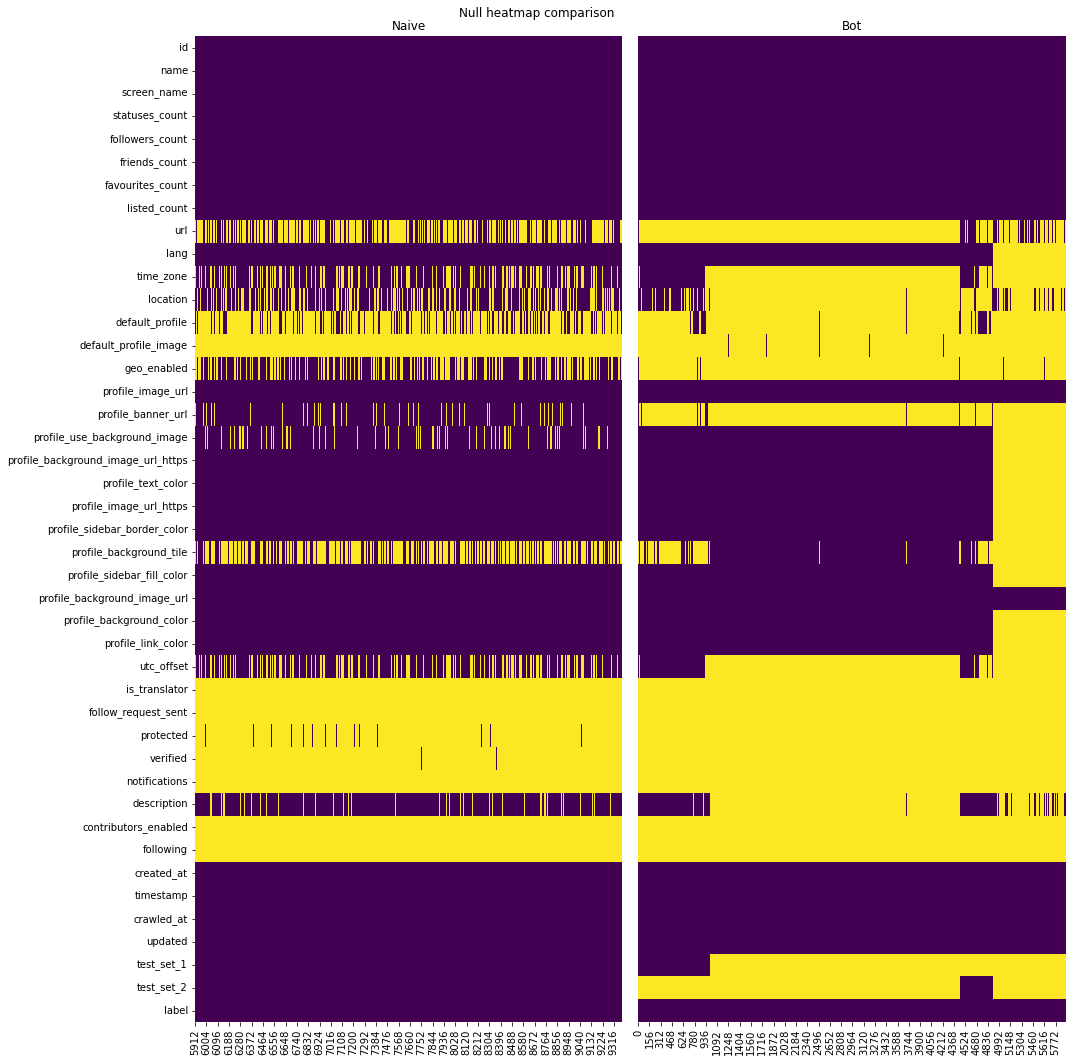

In [10]:
def plot_null_heatmap():
    figure = plt.figure(figsize=(15,15))
    # figure.add_gridspec(1,2)
    ax1 = figure.add_subplot(1,2,1)
    ax2 = figure.add_subplot(1,2,2)
    sns.heatmap(df_naive_before.isnull().transpose(),cbar=False,cmap='viridis', ax = ax1)
    sns.heatmap(df_bot_before.isnull().transpose(),cbar=False, cmap='viridis', ax = ax2, yticklabels= False)
    ax1.set_title('Naive')
    ax2.set_title('Bot')
    figure.patch.set_facecolor('white')
    figure.suptitle('Null heatmap comparison')
    plt.tight_layout()
    plt.show()
plot_null_heatmap()

- YELLOW: null
- PURPLE: normal

### Observation
- **All bots are not protected and not verified**
- Most bots have no description
- Other things seems similar in terms of `null-ness`

# Processing

In [11]:
pipe.preprocess()

Selecting features...
Featuring the data...
 'profile_background_color' 'profile_background_image_url'
 'profile_background_image_url_https' 'profile_banner_url'
 'profile_image_url' 'profile_image_url_https' 'profile_link_color'
 'profile_sidebar_border_color' 'profile_sidebar_fill_color'
 'profile_text_color' 'time_zone' 'timestamp' 'updated' 'url'] will be removed since they are not numeric columns
Preprocessing time:  2.309995174407959


In [12]:
df_user = pipe.dfs
is_bot = df_user[pipe.label_col] == 1
df_bot = df_user[is_bot]
df_naive = df_user[~is_bot]

f'Total: {df_user.shape}'
f'Bot: {df_bot.shape}'
f'User: {df_naive.shape}'

'Total: (9386, 36)'

'Bot: (5912, 36)'

'User: (3474, 36)'

### Recheck invalid values

In [13]:
df_invalid = df_user.isin([np.nan, np.inf, -np.inf]).sum()
df_invalid[df_invalid != 0]

Series([], dtype: int64)

### Drop useless

In [14]:
USELESS_FEATURES = [
    'id', 'test_set_1', 'test_set_2'
]

try:
    df_user = df_user.drop(USELESS_FEATURES + FULL_NAN_FEATURES, axis=1)
    len(df_user.columns)
    df_user.columns
except Exception as e:
    print('Already removed unneeded columns')

29

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'default_profile',
       'default_profile_image', 'geo_enabled', 'profile_use_background_image',
       'profile_background_tile', 'utc_offset', 'is_translator', 'protected',
       'verified', 'label', 'tweet_freq', 'followers_growth_rate',
       'friends_growth_rate', 'favourites_growth_rate', 'listed_growth_rate',
       'followers_friends_ratio', 'screen_name_length',
       'num_digits_in_screen_name', 'name_length', 'num_digits_in_name',
       'description_length', 'screen_name_likelihood', 'age', 'reputation'],
      dtype='object')

# Correlation

In [15]:
df_user.apply(lambda x: x.dtype).unique()

array([dtype('int64'), dtype('float64')], dtype=object)

**All numeric features**

<AxesSubplot:>

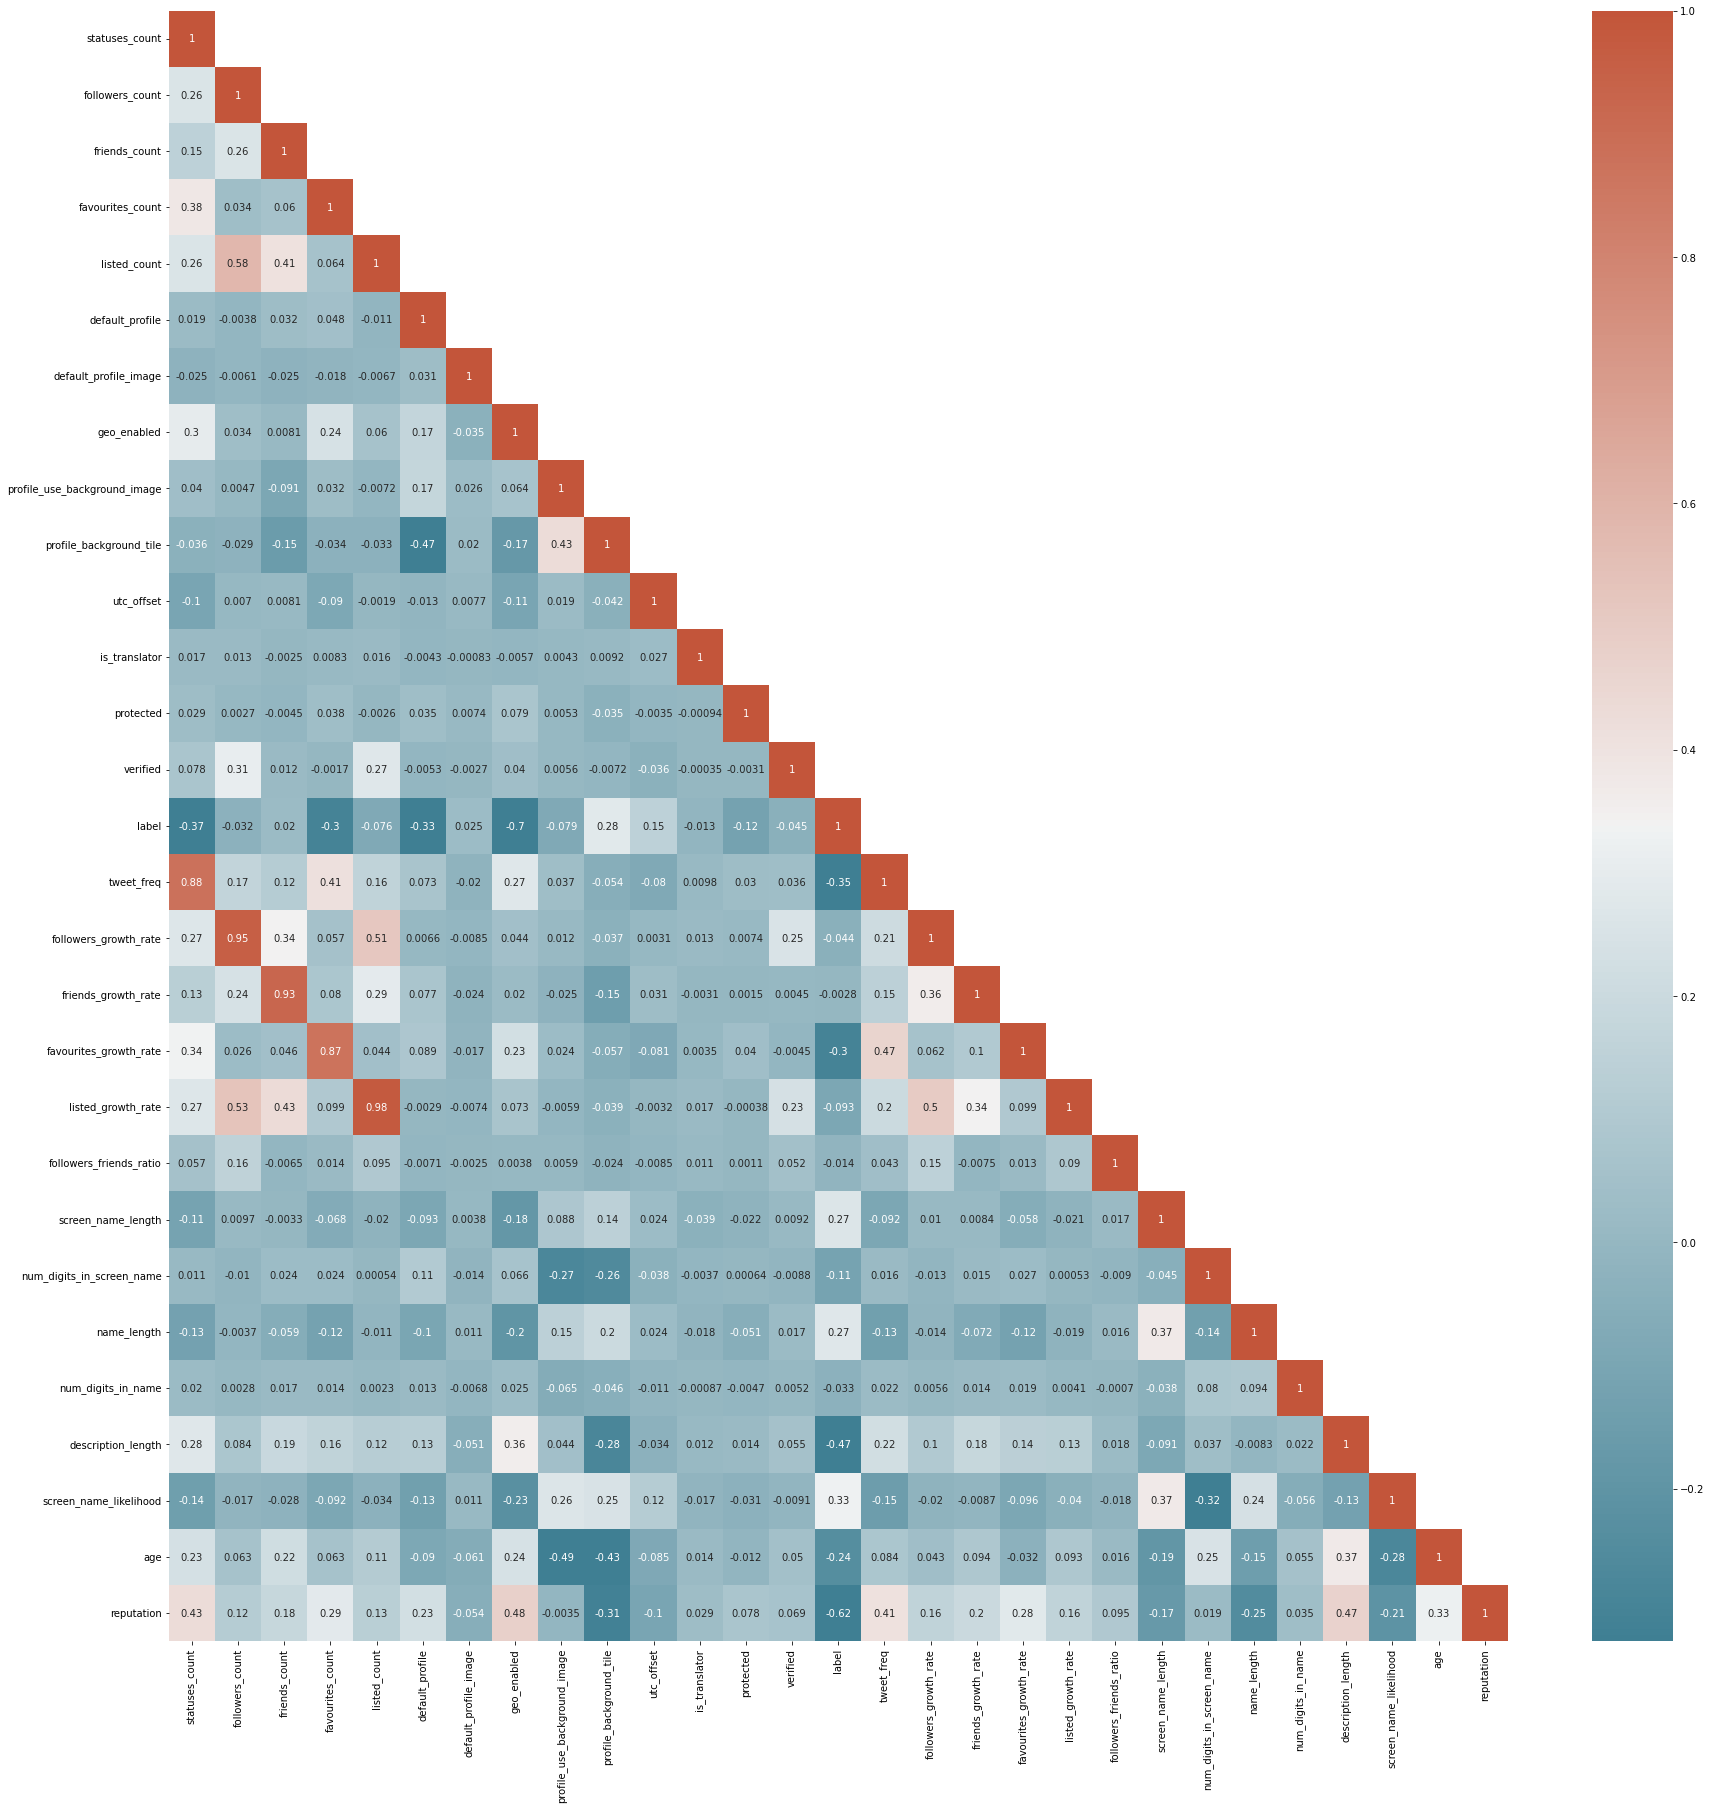

In [16]:
corr = df_user.corr()# plot the heatmap
figure = plt.figure(figsize=(30,30))

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k = 1)] = True

sns.heatmap(
    corr,
    mask=mask,
    robust= True, 
    xticklabels=corr.columns, 
    yticklabels=corr.columns, 
    annot=True, 
    cmap=sns.diverging_palette(220, 20, as_cmap=True)
)
figure.patch.set_facecolor('white')
plt.show()

In [17]:
high_corr = np.abs(corr) > 0.5
matching_indexes = np.where(high_corr)

high_correlated_pairs = set()
for x,y in zip(matching_indexes[0],matching_indexes[1]):
    if x==y: continue
    high_correlated_pairs.add(frozenset({corr.index[x], corr.columns[y]}))

high_correlated_pairs = np.array(list(high_correlated_pairs))
for pair in np.unique(high_correlated_pairs):
    pair = tuple(pair)
    print(f'{pair[0]} - {pair[1]} - {corr.at[pair[0], pair[1]]}')


followers_count - listed_count - 0.5825017415060022
followers_count - followers_growth_rate - 0.9545186715217422
friends_count - friends_growth_rate - 0.9250617862087914
geo_enabled - label - -0.6962487331148298
statuses_count - tweet_freq - 0.877624891231605
favourites_count - favourites_growth_rate - 0.8717759407638836
listed_growth_rate - listed_count - 0.9786659682972267
reputation - label - -0.6220444078780888
listed_growth_rate - followers_growth_rate - 0.5015956193909867
listed_count - followers_growth_rate - 0.514685055204768
listed_growth_rate - followers_count - 0.5306493580018197


## Observations:

### Ultra Correlated
Engineered feature and their components are highly correlated (ofc) (>0.7):
- friends_count - friends_growth_rate
- tweet_freq - statuses_count
- followers_growth_rate - followers_count
- listed_growth_rate - listed_count
- favourites_count - favourites_growth_rate

=> Don't include these together

### Label related
Some feature relate directly with the label:
- reputation
- geo_enabled

=> Could be very useful

### Other mildly related features (~0.5)
- listed_count - followers_count
- listed_growth_rate - followers_count
- followers_growth_rate - listed_growth_rate
- followers_growth_rate - listed_count

=> Unknown relation

# Interesting Statistics

### Bot vs Man on Numbers
follower, friend, list, faavorites

In [18]:
df = df_user.reset_index(drop=True)

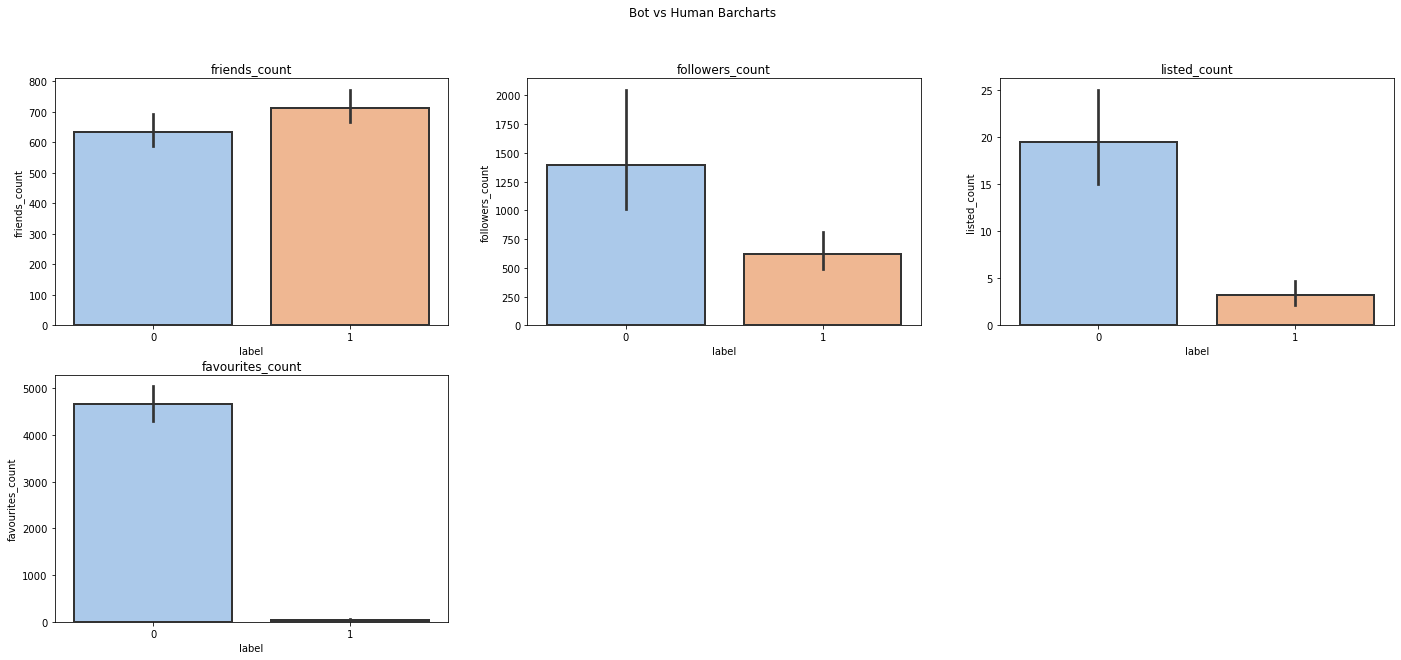

In [19]:
import math
feature_list = [
    'friends_count', 'followers_count', 'listed_count', 'favourites_count',
]

n_cols = min(3, len(feature_list))
n_rows = math.ceil(len(feature_list)/float(n_cols))
figure = plt.figure(figsize=(n_cols*8, n_rows*5))


for i, feature in enumerate(feature_list):
    ax = figure.add_subplot(n_rows, n_cols, i+1)
    sns.barplot(data=df, x='label', palette='pastel', linewidth=2, errcolor=".2", edgecolor=".2", y=feature, ax=ax)
    ax.set_title(feature)
figure.patch.set_facecolor('white')

plt.suptitle('Bot vs Human Barcharts')
plt.show();

Genuine account have way more favor, listed and follower in average

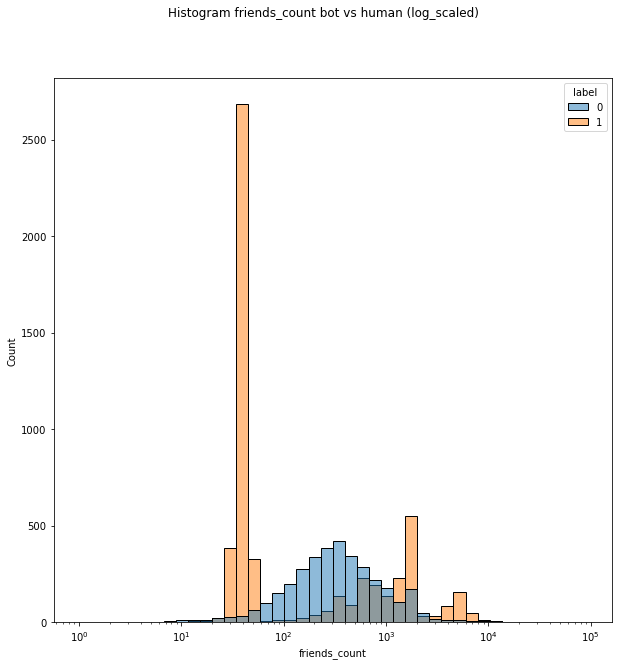

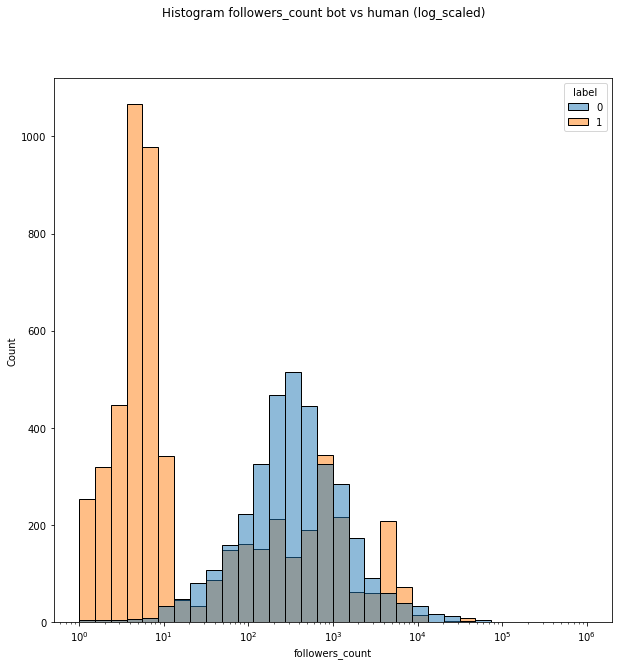

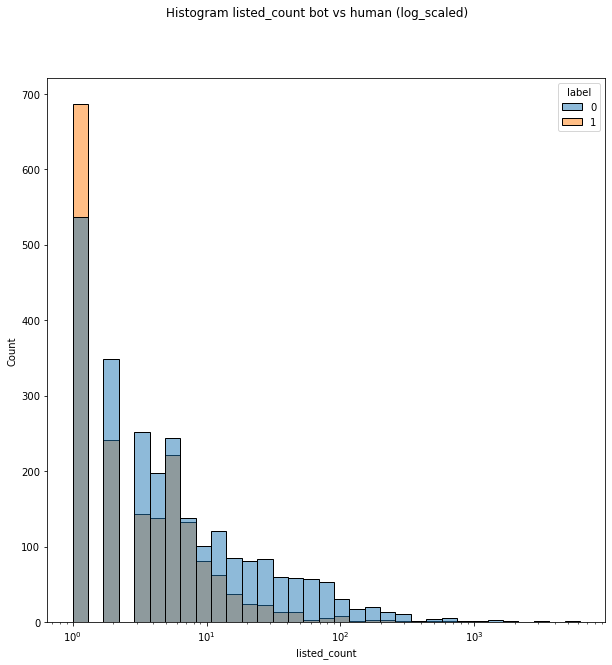

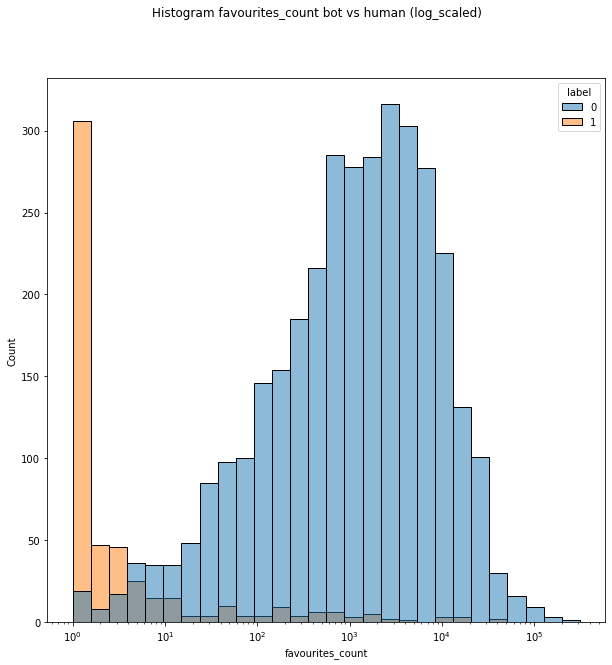

In [20]:
# NOTE
# Histplot looks very ugly since data is high value and not normalized
# So to use with log scale, value >0 need to be selected
#
def plot_log_hist(feature):
    figure = plt.figure(figsize=(10,10))

    test = df[df[feature] > 0.0]
    sns.histplot(data=test, x=feature, hue='label', log_scale=True)

    figure.patch.set_facecolor('white')
    plt.suptitle(f'Histogram {feature} bot vs human (log_scaled)')
    plt.show()
for i, feature in enumerate(feature_list):
    plot_log_hist(feature)

**Observations**
- Human's friend, follower and favorites tend to follow normal distribution
- But bot's trend in these differs quite drastically
- As for listed, both have a tendency to not be listed in many!

## Regional Statistics
By language and timezone

<AxesSubplot:xlabel='label', ylabel='count'>

Text(0.5, 0.98, '#Bot vs #Human (count)')

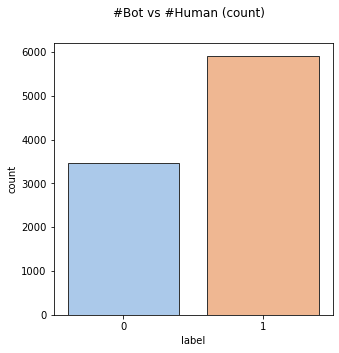

In [21]:
figure = plt.figure(figsize=(5, 5))
sns.countplot(x="label", data=df, palette='pastel', linewidth=1, edgecolor=".2")
figure.patch.set_facecolor('white')
plt.suptitle('#Bot vs #Human (count)')
plt.show()

Decent even sample

In [40]:
# just reconstructing df for plotting since regional data is removed during engineering
bot_regional = df_bot.copy()
bot_regional['label'] = 1
bot_regional['time_zone'] = df_bot_before['time_zone']
bot_regional['lang'] = df_bot_before['lang']
bot_regional['created_at'] = df_bot_before['created_at']
naive_regional = df_naive.copy()
naive_regional['label'] = 0
naive_regional['time_zone'] = df_naive_before['time_zone']
naive_regional['lang'] = df_naive_before['lang']
naive_regional['created_at'] = df_naive_before['created_at']
df_regional = pd.concat([
    bot_regional,
    naive_regional
])
df_regional.columns;

**Note: location is a user input string, not actual region**

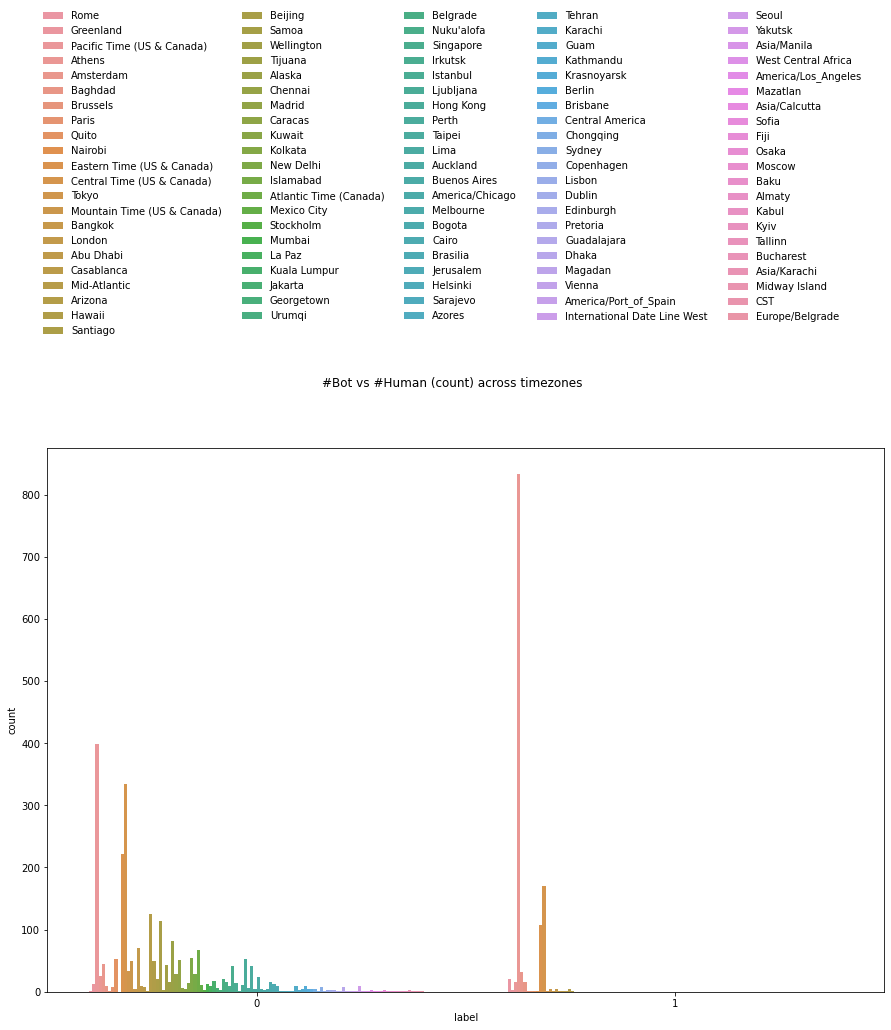

In [41]:
figure = plt.figure(figsize=(15, 10))
plot = sns.countplot(x="label", data=df_regional, hue="time_zone")
h,l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
plot.figure.legend(h,l, 
    ncol=5,loc='upper center', 
    bbox_to_anchor=(0.5, 1.5), frameon=False) # you can specify any location parameter you want here
figure.patch.set_facecolor('white')
plt.suptitle('#Bot vs #Human (count) across timezones')
plt.show();

Interesting that in this dataset, bot seems to come from some timezones only

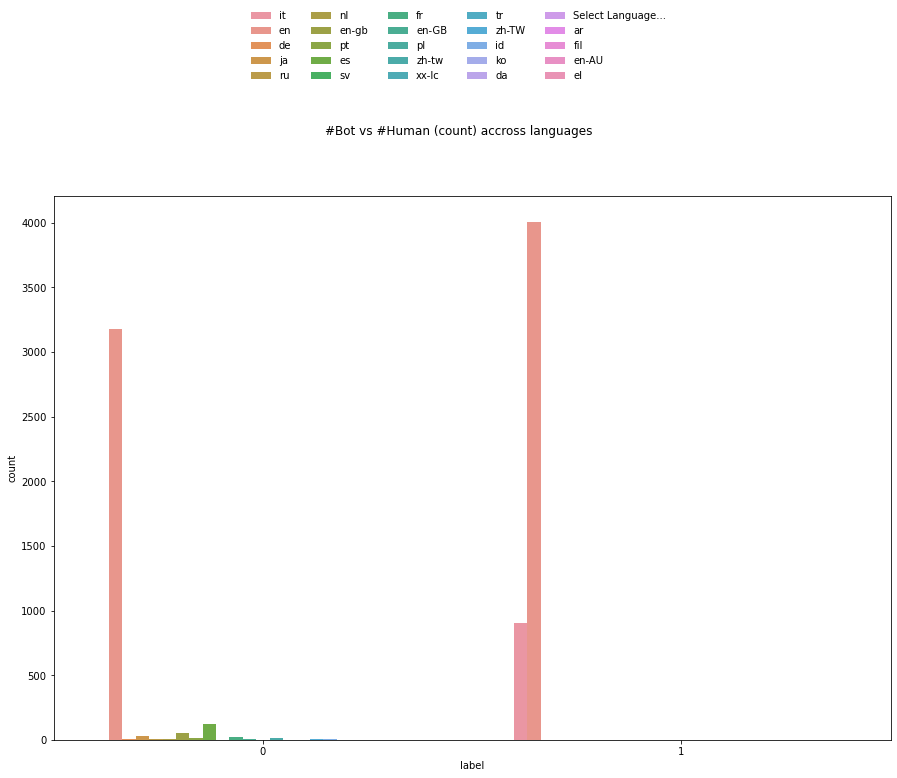

In [42]:
figure = plt.figure(figsize=(15, 10))
plot = sns.countplot(x="label", data=df_regional, hue="lang")
h,l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
plot.figure.legend(h,l, 
    ncol=5,loc='upper center', 
    bbox_to_anchor=(0.5, 1.15), frameon=False) # you can specify any location parameter you want here
figure.patch.set_facecolor('white')
plt.suptitle('#Bot vs #Human (count) accross languages')
plt.show();

Again, bot is less diverse, but
- Everyone likes english
- Seems like italy have a slight bot problem in this dataset

### Verified, Protected and IsTranslation

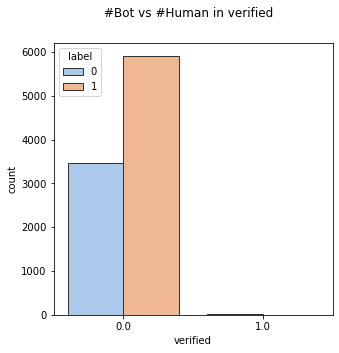

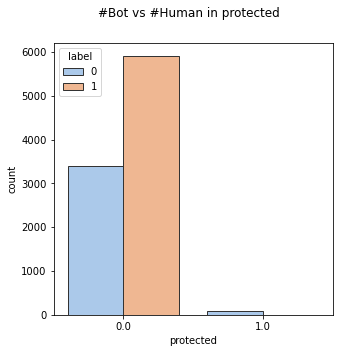

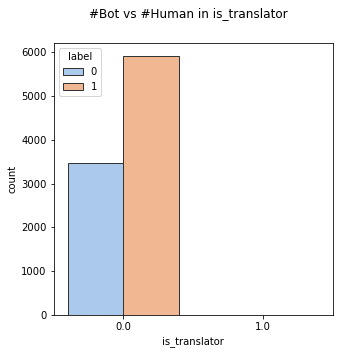

In [43]:
def plot_count_plot_verified(feat):
    figure = plt.figure(figsize=(5, 5))
    sns.countplot(x=feat, data=df, hue = 'label', palette='pastel', linewidth=1, edgecolor=".2")
    figure.patch.set_facecolor('white')
    plt.suptitle(f'#Bot vs #Human in {feat}')
    plt.show()
for feat in ['verified', 'protected', 'is_translator']:
    plot_count_plot_verified(feat)

**NO bots have any kind of these badges**

Humans do, but also, very few of them.

Also clearly that bot account has to be public ✌️

### By Age
age and creation period, any cluster creation?

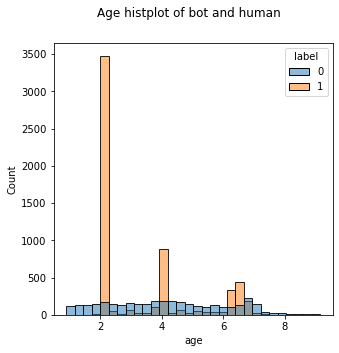

In [44]:
figure = plt.figure(figsize=(5, 5))
sns.histplot(x='age', data=df, hue = 'label')
figure.patch.set_facecolor('white')
plt.suptitle(f'Age histplot of bot and human')
plt.show();

- A more spread out pattern in human age
- Where bot tends to be much younger and their age is concentrated at some ages since they are usually created in bulk

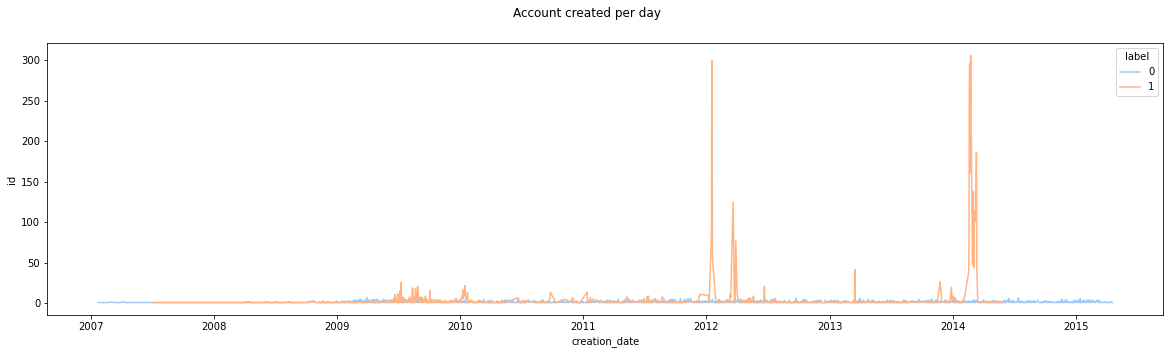

In [45]:
df_regional['creation_date'] = pd.to_datetime(df_regional['created_at']).dt.date
df_by_date = df_regional.groupby(['label', 'creation_date']).count()
df_by_date.columns;
figure = plt.figure(figsize=(20, 5))

sns.lineplot(data=df_by_date, x='creation_date', y='id',hue='label', palette='pastel')
figure.patch.set_facecolor('white')
plt.suptitle(f'Account created per day')
plt.show();

Again there's bulk creation on the side of bot accounts, it can be seen very clear on the timeline chart